# Control moment gyroscope

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_cmg

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_cmg)

<module 'ae353_cmg' from '/Users/timothybretl/Documents/courses/AE353/09 - AE353 (Spring 2021)/Website/projects/01_cmg/ae353_cmg.py'>

Create an instance of the robot simulator. This will open a window in which you should see the platform with a single-gimbal control moment gyroscope.

There are three optional parameters:

* `damping` is the coefficient of viscouse friction at each joint (the default value is `0.`)
* `dt` is the length of each time step in the simulator (the default value is `0.001`)
* `display` is a flag that says whether or not to open the GUI (the default value is `True`)

The `display` parameter, in particular, is likely to be of use to you. If you set `display=True`, then you will run the simulator in real-time with a GUI. If you set `display=False`, then you will run the simulator as fast as possible (faster than real-time) without a GUI. This is convenient when all you want is the data.

**NOTE:** it is still necessary to reset the kernel (see the "Kernel" menu above) before creating a new instance of the robot simulator, even when running without a GUI - if you don't, then you'll notice that simulation slows way down.

In [2]:
robot = ae353_cmg.RobotSimulator(damping=0., dt=0.001, display=True)

Define and create an instance of the robot controller. By default, it chooses to apply zero torque both to the gimbal and to the rotor. Modify the `run` function - or anything else in the class definition - to make the controller behave differently.

In [3]:
class RobotController:
    def __init__(self, dt=0.001):
        self.dt = dt
    
    def run(self, q_1, v_1, q_2, v_2, q_3, v_3):
        tau_2 = 0. # <-- torque applied to gimbal
        tau_3 = 0. # <-- torque applied to rotor
        return tau_2, tau_3

controller = RobotController(dt=robot.dt)

Run the simulation. It is a loop. At each iteration, we:
* get sensor measurements
* choose actuator commands
* go forward one time step

We also log data so that we can plot it later, if we want.

In [4]:
# Restore the simulation to its initial state
robot.reset(rotor_rpm=100.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 10.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q_1': np.empty(num_steps, dtype=float),
    'v_1': np.empty(num_steps, dtype=float),
    'q_2': np.empty(num_steps, dtype=float),
    'v_2': np.empty(num_steps, dtype=float),
    'q_3': np.empty(num_steps, dtype=float),
    'v_3': np.empty(num_steps, dtype=float),
    'tau_2': np.empty(num_steps, dtype=float),
    'tau_3': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q_1, v_1, q_2, v_2, q_3, v_3 = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_2, tau_3 = controller.run(q_1, v_1, q_2, v_2, q_3, v_3)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q_1'][step] = q_1
    data['v_1'][step] = v_1
    data['q_2'][step] = q_2
    data['v_2'][step] = v_2
    data['q_3'][step] = q_3
    data['v_3'][step] = v_3
    data['tau_2'][step] = tau_2
    data['tau_3'][step] = tau_3
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau_2, tau_3)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

An example of how to plot results. This is just an example!

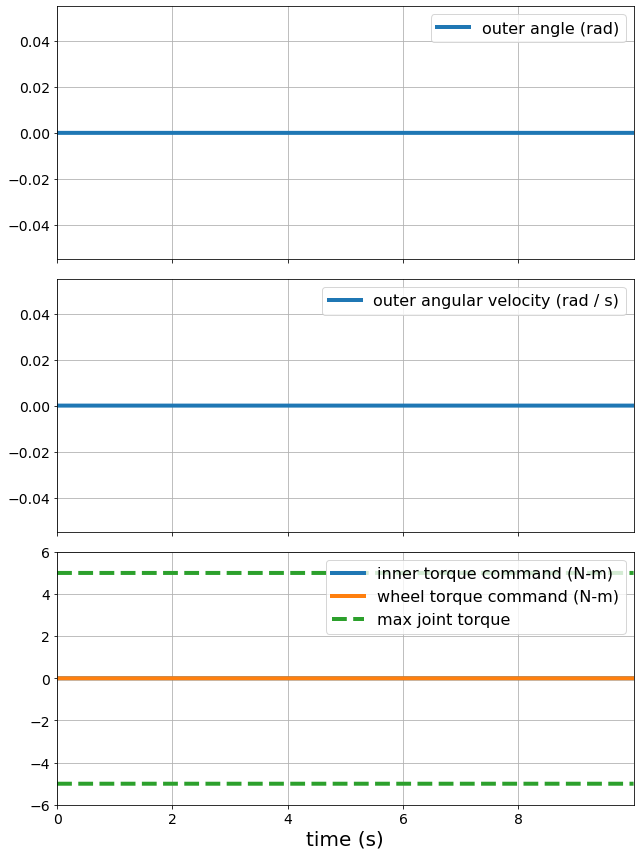

In [5]:
# Create a figure with three subplots, all of which share the same x-axis
fig, ax = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Plot angle of outer gimbal on first subplot
ax[0].plot(data['t'], data['q_1'], label='outer angle (rad)', linewidth=4)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Plot angular velocity of outer gimbal on second subplot
ax[1].plot(data['t'], data['v_1'], label='outer angular velocity (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot torques on third subplot
ax[2].plot(data['t'], data['tau_2'], label='gimbal torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], data['tau_3'], label='rotor torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax[2].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)
ax[2].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[2].set_xlabel('time (s)', fontsize=20)
ax[2].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()